---
title: Regularization methods - lasso, ridge, and elastic net
teaching: 45
exercises: 2
keypoints:
- ""
objectives:
- ""
questions:
- "How can LASSO regularization be used as a feature selection method?"
---

## Introduction to the LASSO Model in high-dimensional data analysis
In the realm of high-dimensional data analysis, where the number of predictors begins to approach or exceed the number of observations, traditional regression methods can become challenging to implement and interpret. The Least Absolute Shrinkage and Selection Operator (LASSO) offers a powerful solution to address the complexities of high-dimensional datasets. This technique, introduced by Robert Tibshirani in 1996, has gained immense popularity due to its ability to provide both effective prediction and feature selection.

The LASSO model is a regularization technique designed to combat overfitting by adding a penalty term to the regression equation. The essence of the LASSO lies in its ability to shrink the coefficients of less relevant predictors towards zero, effectively "shrinking" them out of the model. This not only enhances model interpretability by identifying the most important predictors but also reduces the risk of multicollinearity and improves predictive accuracy.

LASSO's impact on high-dimensional data analysis is profound. It provides several benefits:

* Feature Selection / Interpretability: The LASSO identifies and retains the most relevant predictors. With a reduced set of predictors, the model becomes more interpretable, enabling researchers to understand the driving factors behind the predictions.

* Regularization / Dimensionality Reduction: The L1 penalty prevents overfitting by constraining the coefficients, even in cases with a large number of predictors. The L1 penality inherently reduces the dimensionality of the model, making it suitable for settings where the number of predictors is much larger than the sample size.

* Improved Generalization: Related to the above point, LASSO's feature selection capabilities contribute to better generalization and prediction performance on unseen data.

* Data Efficiency: LASSO excels when working with limited samples, offering meaningful insights despite limited observations.

### The L1 penalty
The key concept behind the LASSO is its use of the L1 penalty, which is defined as the sum of the absolute values of the coefficients (parameters) of the model, multiplied by a regularization parameter (usually denoted as λ or alpha).

In the context of linear regression, the L1 penalty can be incorporated into the ordinary least squares (OLS) loss function as follows:

![LASSO Model](https://www.analyticsvidhya.com/wp-content/uploads/2015/08/Lasso.png)


Where:

* λ (lambda) is the regularization parameter that controls the strength of the penalty. Higher values of λ lead to stronger regularization and more coefficients being pushed towards zero.
* βi is the coefficient associated with the i-th predictor.

The L1 penalty has a unique property that it promotes sparsity. This means that it encourages some coefficients to be exactly zero, effectively performing feature selection. In contrast to the L2 penalty (Ridge penalty), which squares the coefficients and promotes small but non-zero values, the L1 penalty tends to lead to sparse solutions where only a subset of predictors are chosen. As a result, the LASSO automatically performs feature selection, which is especially advantageous when dealing with high-dimensional datasets where many predictors may have negligible effects on the outcome.

### Load full dim, zscored, data

In [5]:
from preprocessing import prep_fulldim_zdata
X_train_z, X_test_z, y_train, y_test, y = prep_fulldim_zdata(const_thresh= 98, test_size=.33, y_log_scaled=True)
X_train_z.head()

GarageYrBlt removed, 81 NaNs
3SsnPorch removed, most_common_val = 0, presence = 98.36
LotFrontage removed, 259 NaNs
MasVnrArea removed, 8 NaNs
LowQualFinSF removed, most_common_val = 0, presence = 98.22
PoolArea removed, most_common_val = 0, presence = 99.52
Condition1_PosA removed, most_common_val = False, presence = 99.45
Condition1_PosN removed, most_common_val = False, presence = 98.7
Condition1_RRAe removed, most_common_val = False, presence = 99.25
Condition1_RRAn removed, most_common_val = False, presence = 98.22
Condition1_RRNe removed, most_common_val = False, presence = 99.86
Condition1_RRNn removed, most_common_val = False, presence = 99.66
RoofStyle_Flat removed, most_common_val = False, presence = 99.11
RoofStyle_Gambrel removed, most_common_val = False, presence = 99.25
RoofStyle_Mansard removed, most_common_val = False, presence = 99.52
RoofStyle_Shed removed, most_common_val = False, presence = 99.86
Condition2_Artery removed, most_common_val = False, presence = 99.86
C

,BedroomAbvGr,YrSold,BsmtHalfBath,WoodDeckSF,OverallQual,KitchenAbvGr,BsmtFinSF2,TotRmsAbvGrd,OverallCond,BsmtFullBath,...,MSSubClass_190,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,SaleType_COD,SaleType_New,SaleType_WD,Electrical_FuseA,Electrical_SBrkr,CentralAir
1127,0.129330,-0.615835,-0.241787,0.379257,0.667268,-0.200227,-0.301116,0.276161,-0.491196,1.123238,...,-0.148058,-0.331647,-0.867132,1.114382,-0.165176,-0.296286,0.379094,-0.271054,0.314285,0.266685
1424,-1.110713,-0.615835,-0.241787,1.718829,-0.797576,-0.200227,2.088865,-0.341883,-0.491196,1.123238,...,-0.148058,-0.331647,1.152047,-0.896440,-0.165176,-0.296286,0.379094,-0.271054,0.314285,0.266685
587,-1.110713,0.867630,-0.241787,-0.742245,-0.797576,-0.200227,-0.301116,-1.577972,0.400065,1.123238,...,-0.148058,-0.331647,1.152047,-0.896440,-0.165176,-0.296286,0.379094,-0.271054,0.314285,0.266685
1157,-1.110713,0.867630,-0.241787,0.597327,0.667268,-0.200227,-0.301116,-0.341883,-0.491196,1.123238,...,-0.148058,-0.331647,-0.867132,1.114382,-0.165176,-0.296286,0.379094,-0.271054,0.314285,0.266685
938,0.129330,-1.357568,-0.241787,-0.742245,0.667268,-0.200227,-0.301116,0.276161,-0.491196,-0.814199,...,-0.148058,-0.331647,-0.867132,1.114382,-0.165176,3.371663,-2.635168,-0.271054,0.314285,0.266685


In [7]:
from regression_predict_sklearn import fit_eval_model
help(fit_eval_model)

Help on function fit_eval_model in module regression_predict_sklearn:

fit_eval_model(y: Union[numpy.ndarray, pandas.core.series.Series], baseline_pred: Union[numpy.ndarray, pandas.core.series.Series], X_train: Union[numpy.ndarray, pandas.core.frame.DataFrame], y_train: Union[numpy.ndarray, pandas.core.series.Series], X_test: Union[numpy.ndarray, pandas.core.frame.DataFrame], y_test: Union[numpy.ndarray, pandas.core.series.Series], predictors: Union[str, List[str]], metric: str, y_log_scaled: bool, model_type: sklearn.linear_model._base.LinearRegression, include_plots: bool, plot_raw: bool, verbose: bool) -> Tuple[float, float, float]
    Fits a linear regression model using specified predictor variables and evaluates its performance.
    
    Args:
        y (Union[np.ndarray, pd.Series]): Actual target values for full dataset (not transformed).
        baseline_pred (Union[np.ndarray, pd.Series]): Array of baseline predictions for full dataset.
        X_train (Union[np.ndarray, pd.D

# of predictor vars = 116
# of train observations = 978
# of test observations = 482
Baseline RMSE = 79415.29188606751
Train RMSE = 24795.18656359946
Holdout RMSE = 69932.67096909003
(Holdout-Train)/Train: 182%


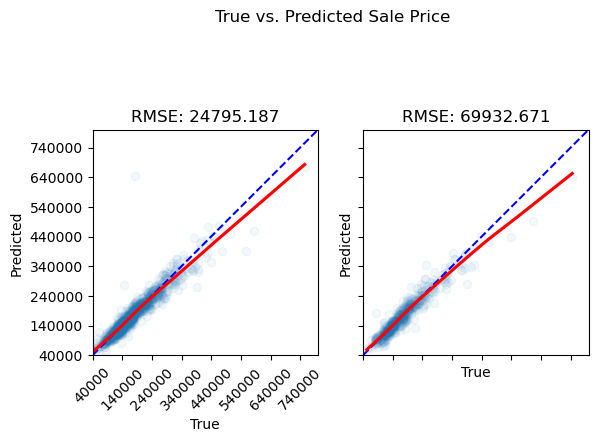

(79415.29188606751, 24795.18656359946, 69932.67096909003)

In [8]:
fit_eval_model(y=y, baseline_pred=y.mean(),
               X_train=X_train_z, y_train=y_train,
               X_test=X_test_z, y_test=y_test, 
               predictors=X_train_z.columns,
               metric='RMSE',
               y_log_scaled=True,
               model_type='unregularized',
               include_plots=True, plot_raw=True, verbose=True)

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

## Optimizing lambda with cross-validation

In [43]:
alphas = np.logspace(-4, 2, 40)
alphas

array([1.00000000e-04, 1.42510267e-04, 2.03091762e-04, 2.89426612e-04,
       4.12462638e-04, 5.87801607e-04, 8.37677640e-04, 1.19377664e-03,
       1.70125428e-03, 2.42446202e-03, 3.45510729e-03, 4.92388263e-03,
       7.01703829e-03, 1.00000000e-02, 1.42510267e-02, 2.03091762e-02,
       2.89426612e-02, 4.12462638e-02, 5.87801607e-02, 8.37677640e-02,
       1.19377664e-01, 1.70125428e-01, 2.42446202e-01, 3.45510729e-01,
       4.92388263e-01, 7.01703829e-01, 1.00000000e+00, 1.42510267e+00,
       2.03091762e+00, 2.89426612e+00, 4.12462638e+00, 5.87801607e+00,
       8.37677640e+00, 1.19377664e+01, 1.70125428e+01, 2.42446202e+01,
       3.45510729e+01, 4.92388263e+01, 7.01703829e+01, 1.00000000e+02])

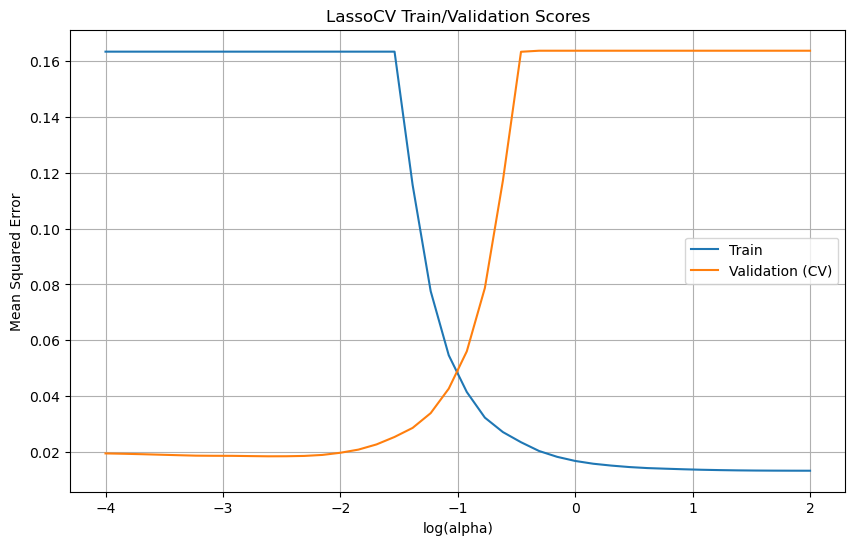

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV

# Create LassoCV model with cross-validation for lambda selection
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train_z, y_train)

# Retrieve the validation scores at each alpha and fold
val_scores = lasso_cv.mse_path_

# Calculate the corresponding training scores for each alpha and fold
from sklearn.linear_model import Lasso
train_scores = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_z, y_train)
    train_scores.append(np.mean((lasso.predict(X_train_z) - y_train) ** 2))

# Plot the training and validation scores
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lasso_cv.alphas_), train_scores, label='Train')
plt.plot(np.log10(lasso_cv.alphas_), val_scores.mean(axis=1), label='Validation (CV)')
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.title('LassoCV Train/Validation Scores')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Plot the training and validation scores
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lasso_cv.alphas_), train_scores, label='Train')
plt.plot(np.log10(lasso_cv.alphas_), val_scores, label='Validation (CV)')
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.title('LassoCV Train/Validation Scores')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Calculate p-values for LASSO coefficients
X_train_with_constant = sm.add_constant(X_train)
lasso_model = sm.OLS(y_train, X_train_with_constant)
lasso_results = lasso_model.fit_regularized(alpha=lasso_cv.alpha_, L1_wt=1.0)

# Print the summary of LASSO results
print(lasso_results.summary())


Define a function `measure_model_err` to help us measure the model's performance (train/test RMSE)

Define a function `fit_eval_model` that will call both `train_linear_model` and `measure_model_err` and report back on model performance.

## Fit multivariate model using all predictor vars

## Regularized regression: ridge, lasso, elastic net


### Ridge and RidgeCV
- Show ridge optimization equation
- Default CV is Leave-One-Out. In this form of CV, all samples in the data except for one are used as the inital training set. The left out sample is used a validation set.
- One alpha value used for entire model; larger alphas give more weight to the penalty/regularization term of the loss function

Edit function below to use multiple regression techniques (add model_type input)





In [ ]:
# import sklearn's ridge model with built-in cross-validation
from sklearn.linear_model import RidgeCV 

# fit model using multivariate_model_feats and ridge regression
RMSE_train, RMSE_test = fit_eval_model(X_train, y_train, X_test, y_test, labels, 'ridge')

- What is the model's train and test error? How does this compare to the unregularized model we fit using all predictor variables? How does this model compare to the best univariate model we fit?
  - The ridge model does much better (i.e., in terms of Test RMSE) than the unregularized model that uses all predictor vars.
  - Unregularized_all_predictors_testRMSE: 3562241001
  - Unregularized_best_univariate_testRMSE: 48243
  - Regularized_all_predictors_testRMSE: 39004

- What alpha value was selected using RidgeCV? Is it a lower or higher value? What does this value tell you about the model?
  - This model is highly regularized/penalized since it has a large alpha value



### LASSO
- explain why there's a random state param in LASSO but not ridge


In [ ]:
# edit train_linear_model to train ridge models as well
def train_linear_model(X_train, y_train, model_type):
    if model_type == "unregularized":
        reg = LinearRegression().fit(X_train,y_train)
    elif model_type == 'ridge':
        reg = RidgeCV(alphas=[1e-3,1e-2,1e-1,1,10,100,1000], store_cv_values=True).fit(X_train,y_train)
        print(reg.cv_values_.shape) # num_datapoints x num_alphas
        print(np.mean(reg.cv_values_, axis=0))
        print(reg.alpha_)
    elif model_type == 'lasso':
        reg = LassoCV(random_state=0, alphas=[1e-3,1e-2,1e-1,1,10,100,1000], max_iter=100000, tol=1e-3).fit(X_train,y_train)
        print(reg.alpha_)
        print(reg.alphas_)

    else:
        raise ValueError('Unexpected model_type encountered; model_type = ' + model_type)

    # print number of estimated model coefficients. Need to add one to account for y-intercept (not included in reg.coef_ call)
    print('# model coefs = ' + str(len(reg.coef_)+1))

    return reg



In [ ]:
# import sklearn's lasso model with built-in cross-validation
from sklearn.linear_model import LassoCV 

# fit model using multivariate_model_feats and ridge regression
RMSE_train, RMSE_test = fit_eval_model(X_train, y_train, X_test, y_test, labels, 'lasso')

Add elastic net option to function

In [ ]:
# edit train_linear_model to train ridge models as well
def train_linear_model(X_train, y_train, model_type):
    if model_type == "unregularized":
        reg = LinearRegression().fit(X_train,y_train)
    elif model_type == 'ridge':
        reg = RidgeCV(alphas=[1e-3,1e-2,1e-1,1,10,100,1000], store_cv_values=True).fit(X_train,y_train)
        print(reg.cv_values_.shape) # num_datapoints x num_alphas
        print(np.mean(reg.cv_values_, axis=0))
        print('alpha:', reg.alpha_)
    elif model_type == 'lasso':
        reg = LassoCV(random_state=0, alphas=[1e-3,1e-2,1e-1,1,10,100,1000], max_iter=100000, tol=1e-3).fit(X_train,y_train)
        print('alpha:', reg.alpha_)
        print('alphas:', reg.alphas_)
    elif model_type == 'elastic':
        reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],alphas=[1e-5,1e-4,1e-3,1e-2,1e-1,1,10]).fit(X_train,y_train)
        print('alpha:', reg.alpha_)
        print('l1_ratio:', reg.l1_ratio_)
    else:
        raise ValueError('Unexpected model_type encountered; model_type = ' + model_type)

    # print number of estimated model coefficients. Need to add one to account for y-intercept (not included in reg.coef_ call)
    print('# model coefs = ' + str(len(reg.coef_)+1))

    return reg



In [ ]:
from sklearn.linear_model import ElasticNetCV

# fit model using multivariate_model_feats and ridge regression
RMSE_train, RMSE_test = fit_eval_model(X_train, y_train, X_test, y_test, labels, 'elastic')

In [ ]:
# Diabetes dataset

# from sklearn import datasets
# example datasets from sklean: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes
# iris_X, iris_y = datasets.load_iris(return_X_y=True)
# more info on diabetes dataset: https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset
# diabetes = datasets.load_diabetes(return_X_y=False,as_frame=False)
# print(type(diabetes))
# feat_names=diabetes['feature_names']
# print(feat_names)
# data=diabetes['data']
# target=diabetes['target'] # the target is a quantitative measure of disease progression one year after baseline
# print(data.shape)
# print(target.shape)
# print(diabetes_X.shape) # 442 observations, 10 features
# diabetes_y

# California housing dataset

# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing()
# # housing
# feat_names=housing['feature_names']
# print(feat_names)
# print(len(feat_names))